In [ ]:
import json
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from llm4netlab.config import BASE_DIR, RESULTS_DIR

os.chdir(BASE_DIR)

# set the max rows to display to 100
pl.Config.set_tbl_rows(50)

plt.rcParams.update(
    {
        "font.size": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "lines.linewidth": 1,
        "figure.dpi": 300,
    }
)

palette_1 = plt.get_cmap("Set1")([0, 1, 2])

In [208]:
eval_results_df = pl.read_csv("/home/ubuntu/codes/LLM4NetLab/results/0_summary/evaluation_summary.csv")
# eval_results_df = eval_results_df.with_columns(
#     pl.when(pl.col("scenario_topo_size") == "-")
#     .then(pl.lit("s"))
#     .otherwise(pl.col("scenario_topo_size"))
#     .alias("scenario_topo_size")
# )

In [146]:
# get reasoning tokens statistics
reasoning_tokens_df = []

for row in eval_results_df.iter_rows(named=True):
    dst_dir = os.path.join(RESULTS_DIR, row["root_cause_name"], str(row["session_id"]))
    conv_file = os.path.join(dst_dir, "conversation_diagnosis_agent.log")
    if not os.path.exists(conv_file):
        print(f"Conversation file not found: {conv_file}")
        print(row)
        continue

    with open(conv_file, "r") as f:
        tot_reas_session_tokens = 0
        for line in f:
            record = json.loads(line)
            if record["event"] == "llm_end":
                reas_tokens = record["usage_metadata"]["output_token_details"]["reasoning"]
                tot_reas_session_tokens += reas_tokens

        reasoning_tokens_df.append({"session_id": row["session_id"], "reasoning_tokens": tot_reas_session_tokens})
reasoning_tokens_df = pl.DataFrame(reasoning_tokens_df)
eval_results_df = eval_results_df.join(reasoning_tokens_df, on="session_id", how="left")

In [148]:
eval_results_df.head()

agent_type,backend_model,root_cause_category,root_cause_name,net_env,scenario_topo_size,session_id,in_tokens,out_tokens,steps,tool_calls,tool_errors,time_taken,llm_judge_relevance_score,llm_judge_correctness_score,llm_judge_efficiency_score,llm_judge_clarity_score,llm_judge_final_outcome_score,llm_judge_overall_score,detection_score,localization_accuracy,localization_precision,localization_recall,localization_f1,rca_accuracy,rca_precision,rca_recall,rca_f1,reasoning_tokens
str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""react""","""gpt-5-mini""","""end_host_failure""","""dns_record_error""","""ospf_enterprise_dhcp""","""s""",1128131938,146110,11679,13,12,0,284.96,5,5,4,5,5,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9408
"""react""","""gpt-5-mini""","""end_host_failure""","""host_crash""","""dc_clos_bgp""","""s""",1128132729,17995,5285,3,20,4,100.63,5,5,4,5,5,5,1.0,1.0,0.5,1.0,0.6667,1.0,1.0,1.0,1.0,2496
"""react""","""gpt-5-mini""","""end_host_failure""","""host_ip_conflict""","""dc_clos_bgp""","""s""",1128133035,202598,7672,19,24,0,187.47,5,5,5,5,5,5,1.0,0.5,1.0,0.5,0.6667,1.0,0.3333,1.0,0.5,5504
"""react""","""gpt-5-mini""","""end_host_failure""","""host_incorrect_dns""","""ospf_enterprise_dhcp""","""s""",1128134055,30639,6727,2,20,0,183.98,5,5,4,5,5,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3584
"""react""","""gpt-5-mini""","""end_host_failure""","""host_incorrect_gateway""","""ospf_enterprise_dhcp""","""s""",1128135216,174385,14421,13,14,0,311.6,5,5,4,5,4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12416


# reasoning steps v.s. success rate

no obvious pattern

In [184]:
# import seaborn as sns

# model = "gpt-5"
# plt_df = eval_results_df.with_columns(
#     (( pl.col("localization_accuracy"))).alias("total_score")
# )#.filter(pl.col("backend_model") == model)

# # scatter plot
# plt.figure(figsize=(4, 3))
# sns.scatterplot(
#     data=plt_df.to_pandas(),
#     x="reasoning_tokens",
#     y="total_score",
#     hue="scenario_topo_size",
#     palette="Set1",
#     s=10,
# )
# plt.xlabel("Reasoning tokens")
# # plt.xscale("log")
# plt.show()

# LLMs

In [187]:
res = (
    eval_results_df.filter(pl.col("detection_score") != -1)
    .group_by(["backend_model"])
    .agg(
        [
            pl.len().alias("num_cases"),
            pl.col("time_taken").mean().round(2).alias("mean_time_taken"),
            pl.col("steps").mean().round(2).alias("mean_steps"),
            pl.col("tool_calls").mean().round(2).alias("mean_tool_calls"),
            pl.col("tool_errors").mean().round(2).alias("mean_tool_errors"),
            pl.col("in_tokens").mean().round(2).alias("mean_in_tokens"),
            pl.col("out_tokens").mean().round(2).alias("mean_out_tokens"),
            pl.col("reasoning_tokens").mean().round(2).alias("mean_reasoning_tokens"),
            pl.col("detection_score").mean().round(2).alias("mean_detection_accuracy"),
            pl.col("localization_accuracy").mean().round(2).alias("mean_localization_accuracy"),
            pl.col("rca_accuracy").mean().round(2).alias("mean_rca_accuracy"),
        ]
    )
    .sort(["backend_model"], descending=True)
)

res = res.join(
    eval_results_df.filter(pl.col("detection_score") == -1)
    .group_by(["backend_model"])
    .agg(pl.len().alias("num_failed_cases")),
    on="backend_model",
    how="left",
)
display(res)

print(res.to_pandas().to_csv(index=False).replace(",", " & ").replace("\n", "\\ \\ \n"))

backend_model,num_cases,mean_time_taken,mean_steps,mean_tool_calls,mean_tool_errors,mean_in_tokens,mean_out_tokens,mean_reasoning_tokens,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy,num_failed_cases
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32
"""gpt-5-mini""",209,246.01,8.4,14.83,0.35,136826.51,6753.45,4536.04,0.91,0.41,0.35,19
"""gpt-5""",149,311.09,6.81,27.64,0.36,104931.49,14192.44,11997.21,0.9,0.69,0.59,1


backend_model & num_cases & mean_time_taken & mean_steps & mean_tool_calls & mean_tool_errors & mean_in_tokens & mean_out_tokens & mean_reasoning_tokens & mean_detection_accuracy & mean_localization_accuracy & mean_rca_accuracy & num_failed_cases\ \ 
gpt-5-mini & 209 & 246.01 & 8.4 & 14.83 & 0.35 & 136826.51 & 6753.45 & 4536.04 & 0.91 & 0.41 & 0.35 & 19\ \ 
gpt-5 & 149 & 311.09 & 6.81 & 27.64 & 0.36 & 104931.49 & 14192.44 & 11997.21 & 0.9 & 0.69 & 0.59 & 1\ \ 



# Category

In [188]:
res = (
    eval_results_df.filter(pl.col("detection_score") != -1)
    .group_by(["root_cause_category"])
    .agg(
        [
            pl.len().alias("num_cases"),
            pl.col("time_taken").mean().round(2).alias("mean_time_taken"),
            pl.col("steps").mean().round(2).alias("mean_steps"),
            pl.col("tool_calls").mean().round(2).alias("mean_tool_calls"),
            (pl.col("in_tokens") + pl.col("out_tokens")).mean().round(2).alias("mean_total_tokens"),
            pl.col("detection_score").mean().round(2).alias("mean_detection_accuracy"),
            pl.col("localization_accuracy").mean().round(2).alias("mean_localization_accuracy"),
            pl.col("rca_accuracy").mean().round(2).alias("mean_rca_accuracy"),
        ]
    )
    .sort(["mean_rca_accuracy"], descending=True)
)
display(res)
print(res.to_pandas().to_csv(index=False).replace(",", " & ").replace("\n", "\\\\ \n"))

root_cause_category,num_cases,mean_time_taken,mean_steps,mean_tool_calls,mean_total_tokens,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy
str,u32,f64,f64,f64,f64,f64,f64,f64
"""end_host_failure""",79,240.8,7.44,17.85,122280.0,0.86,0.55,0.68
"""network_node_error""",52,249.37,9.04,21.6,127471.21,1.0,0.54,0.54
"""link_failure""",50,212.01,7.36,19.52,96391.92,0.98,0.66,0.44
"""misconfiguration""",90,335.17,8.22,20.54,174008.54,0.88,0.52,0.42
"""resource_contention""",54,289.15,6.54,21.61,111739.57,0.87,0.44,0.33
"""network_under_attack""",33,284.78,7.58,21.0,150144.06,0.91,0.38,0.06


root_cause_category & num_cases & mean_time_taken & mean_steps & mean_tool_calls & mean_total_tokens & mean_detection_accuracy & mean_localization_accuracy & mean_rca_accuracy\\ 
end_host_failure & 79 & 240.8 & 7.44 & 17.85 & 122280.0 & 0.86 & 0.55 & 0.68\\ 
network_node_error & 52 & 249.37 & 9.04 & 21.6 & 127471.21 & 1.0 & 0.54 & 0.54\\ 
link_failure & 50 & 212.01 & 7.36 & 19.52 & 96391.92 & 0.98 & 0.66 & 0.44\\ 
misconfiguration & 90 & 335.17 & 8.22 & 20.54 & 174008.54 & 0.88 & 0.52 & 0.42\\ 
resource_contention & 54 & 289.15 & 6.54 & 21.61 & 111739.57 & 0.87 & 0.44 & 0.33\\ 
network_under_attack & 33 & 284.78 & 7.58 & 21.0 & 150144.06 & 0.91 & 0.38 & 0.06\\ 



# size

In [211]:
res = (
    eval_results_df.filter(pl.col("detection_score") != -1)
    .group_by(["backend_model", "scenario_topo_size"])
    .agg(
        [
            pl.len().alias("num_cases"),
            pl.col("time_taken").mean().round(2).alias("mean_time_taken"),
            pl.col("steps").mean().round(2).alias("mean_steps"),
            pl.col("tool_calls").mean().round(2).alias("mean_tool_calls"),
            (pl.col("in_tokens") + pl.col("out_tokens")).mean().round(2).alias("mean_total_tokens"),
            pl.col("detection_score").mean().round(2).alias("mean_detection_accuracy"),
            pl.col("localization_accuracy").mean().round(2).alias("mean_localization_accuracy"),
            pl.col("rca_accuracy").mean().round(2).alias("mean_rca_accuracy"),
        ]
    )
    .sort(["backend_model", "scenario_topo_size"], descending=True)
)

display(res)
print(res.to_pandas().to_csv(index=False).replace(",", " & ").replace("\n", " \\\\ \n"))

backend_model,scenario_topo_size,num_cases,mean_time_taken,mean_steps,mean_tool_calls,mean_total_tokens,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy
str,str,u32,f64,f64,f64,f64,f64,f64,f64
"""gpt-5-mini""","""s""",91,185.88,9.13,18.08,103468.44,0.93,0.43,0.34
"""gpt-5-mini""","""m""",72,299.67,7.78,12.4,134685.65,0.92,0.48,0.42
"""gpt-5-mini""","""l""",47,282.7,7.74,12.34,239586.7,0.83,0.22,0.3
"""gpt-5-mini""","""-""",12,153.5,8.75,15.17,72469.0,1.0,0.83,0.5
"""gpt-5""","""s""",47,332.56,7.0,29.3,73146.66,0.85,0.7,0.6
"""gpt-5""","""m""",48,267.63,6.56,26.85,83280.38,0.92,0.67,0.6
"""gpt-5""","""l""",48,326.35,6.73,27.42,204862.06,0.92,0.68,0.58
"""gpt-5""","""-""",6,368.49,7.83,22.83,80122.67,1.0,0.83,0.5


backend_model & scenario_topo_size & num_cases & mean_time_taken & mean_steps & mean_tool_calls & mean_total_tokens & mean_detection_accuracy & mean_localization_accuracy & mean_rca_accuracy \\ 
gpt-5-mini & s & 91 & 185.88 & 9.13 & 18.08 & 103468.44 & 0.93 & 0.43 & 0.34 \\ 
gpt-5-mini & m & 72 & 299.67 & 7.78 & 12.4 & 134685.65 & 0.92 & 0.48 & 0.42 \\ 
gpt-5-mini & l & 47 & 282.7 & 7.74 & 12.34 & 239586.7 & 0.83 & 0.22 & 0.3 \\ 
gpt-5-mini & - & 12 & 153.5 & 8.75 & 15.17 & 72469.0 & 1.0 & 0.83 & 0.5 \\ 
gpt-5 & s & 47 & 332.56 & 7.0 & 29.3 & 73146.66 & 0.85 & 0.7 & 0.6 \\ 
gpt-5 & m & 48 & 267.63 & 6.56 & 26.85 & 83280.38 & 0.92 & 0.67 & 0.6 \\ 
gpt-5 & l & 48 & 326.35 & 6.73 & 27.42 & 204862.06 & 0.92 & 0.68 & 0.58 \\ 
gpt-5 & - & 6 & 368.49 & 7.83 & 22.83 & 80122.67 & 1.0 & 0.83 & 0.5 \\ 



In [210]:
eval_results_df.filter(pl.col("detection_score") != -1).group_by("scenario_topo_size").agg(
    [
        pl.len().alias("num_cases"),
        pl.col("detection_score").mean().alias("mean_detection_accuracy"),
        pl.col("localization_accuracy").mean().alias("mean_localization_accuracy"),
        pl.col("rca_accuracy").mean().alias("mean_rca_accuracy"),
    ]
).sort("mean_rca_accuracy", descending=True)

scenario_topo_size,num_cases,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy
str,u32,f64,f64,f64
"""-""",18,1.0,0.833333,0.5
"""m""",120,0.916667,0.554167,0.491667
"""l""",95,0.873684,0.452632,0.442105
"""s""",138,0.905797,0.521739,0.427536


# Task

In [ ]:
# study the acc, precsion and false positiv

In [11]:
eval_results_df.filter(pl.col("detection_score") != -1).group_by(["backend_model", "root_cause_category"]).agg(
    [
        pl.len().alias("num_cases"),
        pl.col("detection_score").mean().alias("mean_detection_accuracy"),
        pl.col("localization_accuracy").mean().alias("mean_localization_accuracy"),
        pl.col("rca_accuracy").mean().alias("mean_rca_accuracy"),
    ]
).sort(["backend_model", "root_cause_category"], descending=True)

backend_model,root_cause_category,num_cases,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy
str,str,u32,f64,f64,f64
"""gpt-5-mini""","""resource_contention""",22,0.909091,0.272727,0.227273
"""gpt-5-mini""","""network_under_attack""",13,0.923077,0.269231,0.076923
"""gpt-5-mini""","""network_node_error""",19,1.0,0.263158,0.421053
"""gpt-5-mini""","""misconfiguration""",40,0.9,0.3625,0.25
"""gpt-5-mini""","""link_failure""",19,0.947368,0.421053,0.368421
"""gpt-5-mini""","""end_host_failure""",35,0.857143,0.385714,0.571429
"""gpt-5""","""resource_contention""",24,0.833333,0.625,0.458333
"""gpt-5""","""network_under_attack""",15,0.866667,0.5,0.066667
"""gpt-5""","""network_node_error""",23,1.0,0.652174,0.73913


In [20]:
eval_results_df.filter(pl.col("detection_score") != -1).group_by(["backend_model", "scenario_topo_size"]).agg(
    [
        pl.len().alias("num_cases"),
        pl.col("detection_score").mean().alias("mean_detection_accuracy"),
        pl.col("localization_accuracy").mean().alias("mean_localization_accuracy"),
        pl.col("rca_accuracy").mean().alias("mean_rca_accuracy"),
    ]
).sort(["backend_model", "scenario_topo_size"], descending=True)

backend_model,scenario_topo_size,num_cases,mean_detection_accuracy,mean_localization_accuracy,mean_rca_accuracy
str,str,u32,f64,f64,f64
"""gpt-5-mini""","""s""",57,0.964912,0.412281,0.385965
"""gpt-5-mini""","""m""",44,0.931818,0.375,0.340909
"""gpt-5-mini""","""l""",47,0.829787,0.223404,0.297872
"""gpt-5""","""s""",53,0.867925,0.716981,0.584906
"""gpt-5""","""m""",14,0.857143,0.785714,0.714286


# Tool invocation analysis

In [25]:
import json

llm_tool_usage_stats = {}

for llm in ["gpt-5-mini", "gpt-5"]:
    detection_tool_usage = {"success": Counter(), "failure": Counter()}
    localization_tool_usage = {"success": Counter(), "failure": Counter()}
    rca_tool_usage = {"success": Counter(), "failure": Counter()}
    all_tool_usage = {"success": Counter(), "failure": Counter()}

    tmp_df = eval_results_df.filter(pl.col("backend_model") == llm)
    for row in tmp_df.iter_rows(named=True):
        dst_dir = os.path.join(RESULTS_DIR, row["root_cause_name"], str(row["session_id"]))
        conv_file = os.path.join(dst_dir, "conversation_diagnosis_agent.log")
        if not os.path.exists(conv_file):
            print(f"Conversation file not found: {conv_file}")
            print(row)
            continue

        with open(conv_file, "r") as f:
            for line in f:
                record = json.loads(line)
                if record["event"] == "tool_start":
                    tool = record["tool"]["name"]
                    if row["detection_score"] == 1:
                        detection_tool_usage["success"][tool] += 1
                    else:
                        detection_tool_usage["failure"][tool] += 1
                    if row["localization_accuracy"] > 0:
                        localization_tool_usage["success"][tool] += 1
                    else:
                        localization_tool_usage["failure"][tool] += 1
                    if row["rca_accuracy"] > 0:
                        rca_tool_usage["success"][tool] += 1
                    else:
                        rca_tool_usage["failure"][tool] += 1
                    # all success
                    if row["detection_score"] == 1 and row["localization_accuracy"] > 0 and row["rca_accuracy"] > 0:
                        all_tool_usage["success"][tool] += 1
                    else:
                        all_tool_usage["failure"][tool] += 1

    llm_tool_usage_stats[llm] = {
        "detection_tool_usage": detection_tool_usage,
        "localization_tool_usage": localization_tool_usage,
        "rca_tool_usage": rca_tool_usage,
        "all_tool_usage": all_tool_usage,
    }

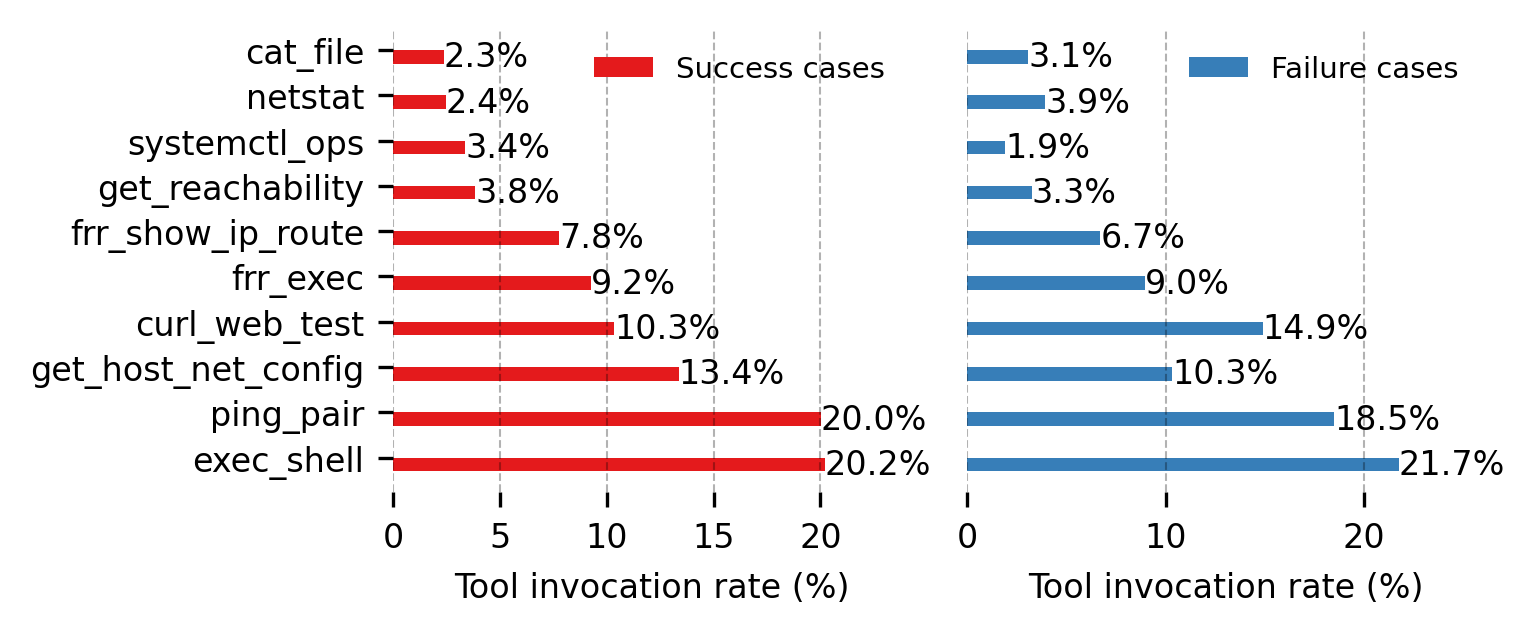

In [140]:
model = "gpt-5"
tool_usage = []

for tool in set(
    list(llm_tool_usage_stats[model]["detection_tool_usage"]["success"].keys())
    + list(llm_tool_usage_stats[model]["detection_tool_usage"]["failure"].keys())
):
    tmp_sample = {"tool": tool}
    for k in ["detection", "localization", "rca", "all"]:
        tmp_success_num = llm_tool_usage_stats[model][f"{k}_tool_usage"]["success"].total()
        tmp_failure_num = llm_tool_usage_stats[model][f"{k}_tool_usage"]["failure"].total()

        tmp_sample[f"{k}_success"] = llm_tool_usage_stats[model][f"{k}_tool_usage"]["success"][tool] / tmp_success_num
        tmp_sample[f"{k}_failure"] = llm_tool_usage_stats[model][f"{k}_tool_usage"]["failure"][tool] / tmp_failure_num
    tool_usage.append(tmp_sample)

tool_usage_df = pl.DataFrame(tool_usage)


# select the top10
plt_df = tool_usage_df.select(["tool", "all_success", "all_failure"]).sort("all_success", descending=True).head(10)

plt.figure(figsize=(5, 2), constrained_layout=True)
bar_width = 0.3
index = np.arange(len(plt_df))

# ---------- 左图：Success ----------
plt.subplot(1, 2, 1)
success_vals = plt_df["all_success"].to_list()
success_vals = [v * 100 for v in success_vals]
plt.barh(index, success_vals, height=bar_width, color=palette_1[0], label="Success cases")

# 标注数值
for i, v in enumerate(success_vals):
    plt.text(v + 0.005, i, f"{v:.1f}%", va="center", ha="left")

plt.xlabel("Tool invocation rate (%)")
# plt.title("(a) Success cases")
plt.legend(frameon=False, fontsize=7)
plt.xlim(0, max(success_vals) * 1.2)
plt.yticks(index + bar_width / 2, plt_df["tool"].to_list())
plt.grid(axis="x", linestyle="--", color="black", linewidth=0.5, alpha=0.3)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# ---------- 右图：Failure ----------
plt.subplot(1, 2, 2)
failure_vals = plt_df["all_failure"].to_list()
failure_vals = [v * 100 for v in failure_vals]
plt.barh(index, failure_vals, height=bar_width, color=palette_1[1], label="Failure cases")

# 标注数值
for i, v in enumerate(failure_vals):
    plt.text(v + 0.005, i, f"{v:.1f}%", va="center", ha="left")

plt.xlabel("Tool invocation rate (%)")
# plt.title("(b) Failure cases")
plt.legend(
    frameon=False,
    fontsize=7,
)
plt.yticks([])
plt.xlim(0, max(failure_vals) * 1.2)

plt.grid(axis="x", linestyle="--", color="black", linewidth=0.5, alpha=0.3)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig(
    f"figs/tool_{model}.pdf",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.01,
    transparent=True,
)
plt.show()

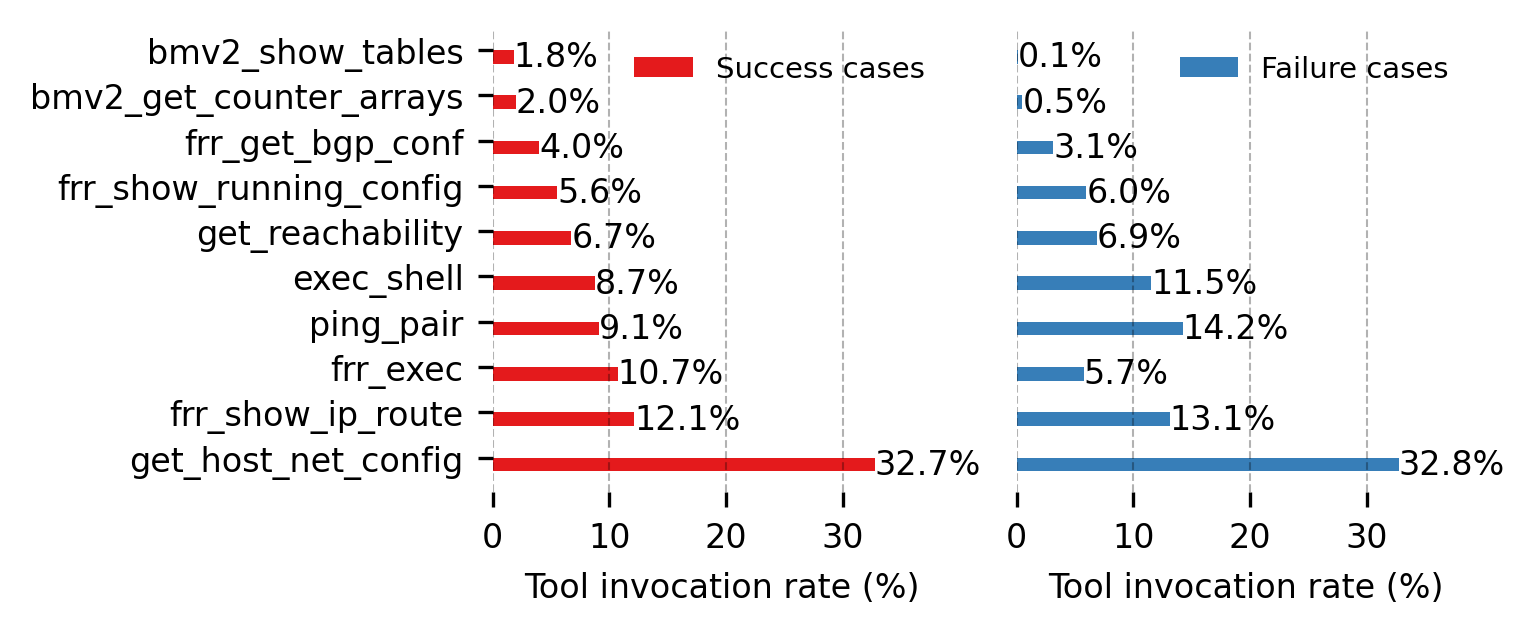

In [ ]:
model = "gpt-5-mini"
tool_usage = []

for tool in set(
    list(llm_tool_usage_stats[model]["detection_tool_usage"]["success"].keys())
    + list(llm_tool_usage_stats[model]["detection_tool_usage"]["failure"].keys())
):
    tmp_sample = {"tool": tool}
    for k in ["detection", "localization", "rca", "all"]:
        tmp_success_num = llm_tool_usage_stats[model][f"{k}_tool_usage"]["success"].total()
        tmp_failure_num = llm_tool_usage_stats[model][f"{k}_tool_usage"]["failure"].total()

        tmp_sample[f"{k}_success"] = llm_tool_usage_stats[model][f"{k}_tool_usage"]["success"][tool] / tmp_success_num
        tmp_sample[f"{k}_failure"] = llm_tool_usage_stats[model][f"{k}_tool_usage"]["failure"][tool] / tmp_failure_num
    tool_usage.append(tmp_sample)

tool_usage_df = pl.DataFrame(tool_usage)


# select the top10
plt_df = tool_usage_df.select(["tool", "all_success", "all_failure"]).sort("all_success", descending=True).head(10)

plt.figure(figsize=(5, 2), constrained_layout=True)
bar_width = 0.3
index = np.arange(len(plt_df))

# ---------- 左图：Success ----------
plt.subplot(1, 2, 1)
success_vals = plt_df["all_success"].to_list()
success_vals = [v * 100 for v in success_vals]
plt.barh(index, success_vals, height=bar_width, color=palette_1[0], label="Success cases")

# 标注数值
for i, v in enumerate(success_vals):
    plt.text(v + 0.005, i, f"{v:.1f}%", va="center", ha="left")

plt.xlabel("Tool invocation rate (%)")
# plt.title("(a) Success cases")
plt.legend(frameon=False, fontsize=7)
plt.xlim(0, max(success_vals) * 1.2)
plt.yticks(index + bar_width / 2, plt_df["tool"].to_list())
plt.grid(axis="x", linestyle="--", color="black", linewidth=0.5, alpha=0.3)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# ---------- 右图：Failure ----------
plt.subplot(1, 2, 2)
failure_vals = plt_df["all_failure"].to_list()
failure_vals = [v * 100 for v in failure_vals]
plt.barh(index, failure_vals, height=bar_width, color=palette_1[1], label="Failure cases")

# 标注数值
for i, v in enumerate(failure_vals):
    plt.text(v + 0.005, i, f"{v:.1f}%", va="center", ha="left")

plt.xlabel("Tool invocation rate (%)")
# plt.title("(b) Failure cases")
plt.legend(
    frameon=False,
    fontsize=7,
)
plt.yticks([])
plt.xlim(0, max(failure_vals) * 1.2)

plt.grid(axis="x", linestyle="--", color="black", linewidth=0.5, alpha=0.3)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig(
    f"figs/tool_{model}.pdf",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.01,
    transparent=True,
)
plt.show()

In [ ]:
# 场景和tool的热力图

## check shell tool invocation

In [ ]:
import ast
import json
from collections import Counter

cmd_exec_counter = Counter()

common_cmd_list = [
    "ping ",
    "traceroute ",
    "ip neigh",
    "dig ",
    "nslookup ",
    "curl ",
    "ip route",
    "ip link",
    "iptables ",
    "arping ",
    "ps ",
    "tcpdump ",
    "cat ",
    "ls ",
]

for row in eval_results_df.iter_rows(named=True):
    dst_dir = os.path.join(RESULTS_DIR, row["root_cause_name"], str(row["session_id"]))
    conv_file = os.path.join(dst_dir, "conversation_diagnosis_agent.log")
    if not os.path.exists(conv_file):
        print(f"Conversation file not found: {conv_file}")
        print(row)
        continue

    with open(conv_file, "r") as f:
        for line in f:
            record = json.loads(line)
            if record["event"] == "tool_start":
                if record["tool"]["name"] == "exec_shell":
                    cmd = ast.literal_eval(record["input"])
                    if "command" in cmd:
                        cmd = cmd["command"]
                        for common_cmd in common_cmd_list:
                            if common_cmd in cmd:
                                cmd_exec_counter[common_cmd] += 1

cmd_exec_counter

Counter({'ping': 279,
         'ip neigh': 219,
         'ip route': 109,
         'curl': 99,
         'cat': 88,
         'iptables': 70,
         'ps': 39,
         'dig': 32,
         'tcpdump': 24,
         'ip link': 16,
         'traceroute': 14,
         'ls': 14,
         'nslookup': 13,
         'arping': 11})

## tool errors

In [85]:
import json
from collections import Counter

for row in eval_results_df.iter_rows(named=True):
    dst_dir = os.path.join(RESULTS_DIR, row["root_cause_name"], str(row["session_id"]))
    conv_file = os.path.join(dst_dir, "conversation_diagnosis_agent.log")
    if not os.path.exists(conv_file):
        print(f"Conversation file not found: {conv_file}")
        print(row)
        continue

    with open(conv_file, "r") as f:
        for line in f:
            record = json.loads(line)
            if record["event"] == "tool_error":
                print(f"Tool error in session {row['session_id']}, {row['root_cause_name']}, {record['output']}")

Tool error in session 1128132729, host_crash, content='Error executing tool get_reachability: 409 Client Error for http+docker://localhost/v1.52/containers/8578094f23079d7ac60c6d957030e4a9018b8fa4ba9eb76b5427b935131106a7/exec: Conflict ("container 8578094f23079d7ac60c6d957030e4a9018b8fa4ba9eb76b5427b935131106a7 is not running")' name='get_reachability' tool_call_id='call_LKkdtRVm6S7VVHQD2iVsWNvs' status='error'
Tool error in session 1128132729, host_crash, content='Error executing tool get_host_net_config: 409 Client Error for http+docker://localhost/v1.52/containers/8578094f23079d7ac60c6d957030e4a9018b8fa4ba9eb76b5427b935131106a7/exec: Conflict ("container 8578094f23079d7ac60c6d957030e4a9018b8fa4ba9eb76b5427b935131106a7 is not running")' name='get_host_net_config' tool_call_id='call_KxNnqxUAfcM97PC9zVHjZnJU' status='error'
Tool error in session 1128132729, host_crash, content='Error executing tool ping_pair: 409 Client Error for http+docker://localhost/v1.52/containers/8578094f23079d7

## tool by different LLMs